# Programming Assignment 3: Neural ODEs, Neural Operators and Phyiscs Informed Neural Networks

### Instructor: Yuanyuan Shi

### Teaching Assistants

- Luke Bhan
- Yuexin Bian
- Rich Pai
- Zekai Zhao

### Questions
Please email any questions to [ece228tas@gmail.com]. 

## Instructions
1. This assignment must be completed individually.  
2. This notebook contains skeleton code, which should not be modified
3. You must run all cells in this notebook and submit this notebook as an .ipynb file.
4. You must submit the .ipynb on Gradescope. You must mark each problem on Gradescope in the pdf.
5. The homework requires the following packages and corresponding versions (other versions may work, but the homework is tested with the given versioning):
    - Python: Version 3.10.12
    - PyTorch: Version >=2.6.0
    - Torchdiffeq: Version 0.2.5
    - numpy: Any recent version.
    - sklearn: Any recent version.
    - matplotlib: Any recent version.
      
Note: all are installed with venv as conda is deprecated with recent versions of pytorch. 

7. Please ensure all of the datasets given is copied into the working data (and unzipped).

In [49]:
from torchdiffeq import odeint
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from plots import vector_field_plt 
import matplotlib.pyplot as plt
import math
import matplotlib.animation as animation
from IPython.display import Video
import random
import time
import torch.nn.functional as F

### Question 2 (30 points total): Build out a neural ODE model. This will consist of three parts.  
1. Build out a classic MLP class (5pts, Use torch. Feel free to make your own design decisions. Activation function, number of layers, etc. You will defend these design decisions later.)
1. Using torchdiffeq, build out a solver as a torch class that integrates your MLP design as a neural ODE. You may find it useful to additionally add a method for generating the entire trajectory. (5pts)
3. Combine the above two classes into a final NeuralODE archtecture. This is up to your design decision completely.(5pts)
4. Answer discussion questions (15pts)
We provide a template for each type of problem and ask that you don't modify the parameter inputs and outputs for testing. However, the methods can be implemented however you choose!

### <font size='4' color='orange'>Task 2.1: Implement a MLP (5 points)</font> 

In [53]:
class MLP(nn.Module):
    # num_layers: The number of layers in the MLP.
    # input_dim: Input dimension of the data. Notice the actual MLP will take a vector of size input_dim + 1 for the time
    # hidden_dims: An array containing the hidden dimensions for the MLP.  
    # output_dim: Output dimension of the data. 
    # acitvation_func: A torch activation function used for the nonlinearity. 
    def __init__(self, num_layers, input_dim, hidden_dims, output_dim, activation_func):
        super(MLP, self).__init__()
        # Your code goes here
        layers = []
        layers.append(nn.Linear(input_dim + 1, hidden_dims[0]))  # +1 to account for time t
        layers.append(activation_func)

        for i in range(1, num_layers - 1):
            layers.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
            layers.append(activation_func)

        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        self.network = nn.Sequential(*layers)

    # t represents the current time which will be apart of our ODE input. The inputs can be of the following form:
    # x=(batch_size, x_dim, 1), t=None
    # x=(batch_size, x_dim, 1), t=Scalar
    # x=(batch_size, x_dim, 1), t=(batch_size, x_dim, 1)
    def forward(self, t=None, x=None):
        # Case where t not given, let it be 1
        if t is None:
            t =  torch.ones(x.shape[0], 1, device=x.device)
        # Case where t given as scalar or a single tensor value, concatenate it len(x) times
        elif isinstance(t, float) or t.ndim == 0:
            t = torch.ones(x.shape[0], 1, device=x.device)*t
        # Case we have enough t values specified, do nothing
        else: 
            t = t.to(x.device)
        # Your code goes here. 
        x = x.unsqueeze(1) if x.ndim == 1 else x
        t = t.unsqueeze(1) if t.ndim == 1 else t
        xt = torch.cat([x, t], dim=1)
        xt = xt.to(next(self.parameters()).device)
        return self.network(xt)

In [63]:
# Simple test of your neural network. Learn a simple quadratic function $f(x) = a*x^2 + bx + c over $[-10, 10]$

# Define your set of parameters
epochs = 2000
batch_size = 64
learning_rate = 1e-3
step_size= 400

# Load the dataset.
# All files are in the form of batch_size, (x, t) or batch_size, f(x, t). 
x_train = np.load("datasets/x_train_quad.npy")
x_test = np.load("datasets/x_test_quad.npy")
y_train = np.load("datasets/y_train_quad.npy")
y_test = np.load("datasets/y_test_quad.npy")

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

# Create Tensor Datasets
trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [65]:
# We have setup the training loop for you. You may need to modify the loop slighty to ensure 
# the correct gpu/cpu is chosen depending on your machine.

# Create your model here
activation = nn.Tanh()
model = MLP(num_layers=3, input_dim=1, hidden_dims=[128, 128], output_dim=1, activation_func=activation)

model.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(model.device)

# Model: pass the model to be trained
# trainData: pass the training data
# testData: pass the testing data
# learning_rate: pass the initial learning rate
# step_size: pass the initial step size for the learning rate scheduler
def trainer(model, trainData, testData, learning_rate, step_size, epochs, output_rate, problem_type="MLP"):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)
    loss = torch.nn.MSELoss()
    for ep in range(epochs):
        model.train()
        train_loss = 0
        for x_vals, y_vals in trainData:
            x_vals, y_vals = x_vals.to(model.device), y_vals.to(model.device)
            optimizer.zero_grad()
            if problem_type=="MLP":
                out = model(t=x_vals[:, 1], x=x_vals[:, 0])
            elif problem_type=="NeuralODE":
                out = model(x=x_vals)
            else:
                raise Exception("Problem type not supported")

        
            lp = loss(out, y_vals)
            lp.backward()
                
            optimizer.step()
            train_loss += lp.item()
    
        scheduler.step()
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x_vals, y_vals in testData:
                x_vals, y_vals = x_vals.to(model.device), y_vals.to(model.device)
                if problem_type=="MLP":
                    out = model(t=x_vals[:, 1], x=x_vals[:, 0])
                elif problem_type=="NeuralODE":
                    out = model(x=x_vals)
                else:
                    raise Exception("Problem type not supported")
    
                test_loss += loss(out, y_vals).item()
        train_loss /= len(trainData)
        test_loss /= len(testData)
        if ep%output_rate == 0:
                print(ep, train_loss, test_loss)
    return model

In [67]:
# output_rate: controls how often the train and lest loss are printed every output_rate steps.
output_rate = 100
model = trainer(model, trainData, testData, learning_rate, step_size, epochs, output_rate)

0 533.2299173990885 545.2186737060547
100 0.6849882746736209 0.5931440889835358
200 0.09437643190224966 0.11642462760210037
300 0.061343419924378396 0.08568534627556801
400 0.018074566684663295 0.02923833392560482
500 0.007579519351323446 0.01087193051353097
600 0.011789346300065517 0.012156510259956121
700 0.005357983615249395 0.011291660368442535
800 0.01558214744242529 0.010732420720160007
900 0.005486578789229194 0.0036337892524898052
1000 0.002079805607597033 0.0014589578204322606
1100 0.0012141673321214815 0.0013005377841182053
1200 0.0011548427544767037 0.0024358336231671274
1300 0.0013044807050998013 0.0013320395373739302
1400 0.0018135277243951956 0.0015787745942361653
1500 0.0019657335088898737 0.004496178589761257
1600 0.0009954511284983407 0.0018016672693192959
1700 0.0009298683687423666 0.001461928040953353
1800 0.0008340656582731754 0.0007014864240773022
1900 0.001494139754989495 0.0010604092967696488


In [69]:
# Test your model. To receive full credit, model must achieve an L2 test loss of 2e-3. 
def test_model(testData, model, tol, problem_type):
    model.eval()
    loss= torch.nn.MSELoss()
    with torch.no_grad():
        test_loss = 0
        for x_vals, y_vals in testData:
            x_vals, y_vals = x_vals.to(model.device), y_vals.to(model.device)
            if problem_type=="MLP":
                out = model(t=x_vals[:, 1], x=x_vals[:, 0])
            elif problem_type=="NeuralODE":
                out = model(x=x_vals)
            else:
                raise Exception("Problem type not supported")
    
            test_loss += loss(out, y_vals).item()
        test_loss /= len(testData)
    if(test_loss <= tol):
        print("TEST PASSED")
    else:
        print("TEST FAILED")
test_model(testData, model, 2e-3, "MLP")

TEST PASSED


### <font size='4' color='orange'>Task 2.2: Implement a Standard Neural ODE (5 points)</font> 

In [72]:
# A single neural ODE layer

class NeuralODEBlock(nn.Module):
    # nueral_ode_model: Contains the neural network model to use for \dot{x} = f(x) 
    # tolerance: Controls the tolerance of the ODE solver
    # max_steps: The max number of ODE solver steps to take
    def __init__(self, neural_ode_model, tolerance, max_steps):
        super(NeuralODEBlock, self).__init__()
        # Your code goes here:
        self.ode_model = neural_ode_model
        self.tolerance = tolerance
        self.max_steps = max_steps

    # times: Controls the times at which the neural ODE is evaluated at 
    # Only returns the final time at t=T. If times=None, make times be torch.tensor([0, 1]). 
    def forward(self, times, x):
        # Setup times for students. 
        if times is None:
            times = torch.tensor([0, 1]).float().type_as(x)
        # Your code goes here
        t = torch.tensor([0., 1.], device=x.device)
        out = odeint(self.ode_model, x, t, 
                     rtol=self.tolerance, 
                     atol=self.tolerance, 
                     method="dopri5", 
                     options={'max_num_steps': self.max_steps})
        return out[1] 

    # Returns the entire trajecotry with timesteps discretization    
    def trajectory(self, timesteps, x):
        # Setup time trajectory for students. 
        times = torch.linspace(0, 1, timesteps, device=x.device)
        # Your code goes here:
        out = odeint(self.ode_model, x, times.to(x.device), 
                     rtol=self.tolerance, 
                     atol=self.tolerance, 
                     method="dopri5", 
                     options={'max_num_steps': self.max_steps})
        return out

In [74]:
# A full neural ODE. Build a neural ODE with a MLP as its base.

class NeuralODE(nn.Module):
    # num_layers: The number of layers in the MLP of the neural ODE.
    # input_dim: Input dimension of the data.
    # hidden_dims: An array containing the hidden dimensions for the MLP of the neural ODE.  
    # output_dim: Output dimension of the data. 
    # activation_func: A torch activation function used for the nonlinearity. 
    # tolerance: Tolerance for the ODE solver
    # max_steps: Max steps for the ODE solver
    def __init__(self, num_layers, input_dim, hidden_dims, output_dim, activation_func, tolerance, max_steps):
        super(NeuralODE, self).__init__()
        self.ode_model = MLP(num_layers=num_layers,
                           input_dim=input_dim,
                           hidden_dims=hidden_dims,
                           output_dim=output_dim,
                           activation_func=activation_func)
        self.block = NeuralODEBlock(self.ode_model, tolerance, max_steps)

    # times: The integration times. Can be set to $[0, 1]$ for this exercise. 
    def forward(self, times=None, x=None):
        # Your code goes here.
        return self.block.forward(times, x)

    def trajectory(self, timesteps=None, x=None):
        # Your code goes here. 
        return self.block.trajectory(timesteps, x)

In [76]:
# Load the SIMPLE dataset. 
x_train = np.load("datasets/x_train_ode_simple.npy")
x_test = np.load("datasets/x_test_ode_simple.npy")
y_train = np.load("datasets/y_train_ode_simple.npy")
y_test = np.load("datasets/y_test_ode_simple.npy")

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

# Setup training and testing datasets as before. 
trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

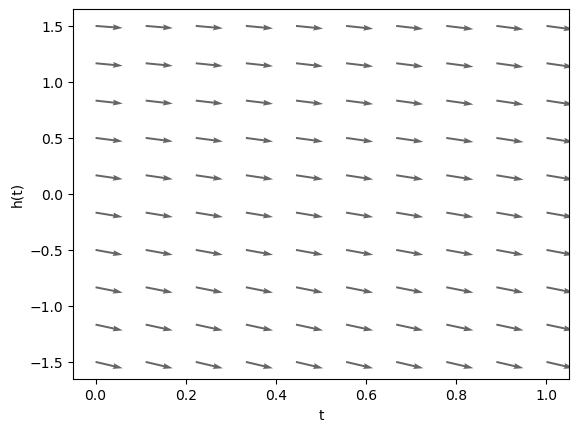

In [78]:
# Visualize ODE plot without training
# Create a neural ODE assigning to the variable neuralODE. 
neuralODE = NeuralODE(
    num_layers=3,
    input_dim=1,
    hidden_dims=[32, 32],
    output_dim=1,
    activation_func= nn.Tanh(),
    tolerance=1e-3,
    max_steps=1000,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
neuralODE = neuralODE.to(device)
neuralODE.device = device
neuralODE.MLPNeuralODE = neuralODE.ode_model
# Use the inner MLP to plot
vector_field_plt(neuralODE.MLPNeuralODE, num_points=10, timesteps=10, 
                 h_min=-1.5, h_max=1.5)

In [82]:
# Train a neural ODE. Choose your parameters. 
neuralODE = trainer(neuralODE, trainData, testData, learning_rate, step_size, epochs, output_rate=100, problem_type="NeuralODE")

0 0.007209198016565866 0.0023835449828766286
100 3.1011857751869127e-07 3.5055567337849425e-07
200 1.5736377261095395e-08 1.7875299240799336e-08
300 1.1775950471159236e-09 1.386957937388189e-09
400 4.669027386938751e-10 4.5400616599522436e-10
500 2.1080812309457123e-10 2.0889029395121383e-10
600 4.2922524509018206e-11 2.4319116165294474e-11
700 6.521919756389357e-13 5.149214388211476e-13
800 1.8839630710177655e-14 5.412337245047638e-15
900 4.550206365540642e-14 1.1324274851176597e-14
1000 1.9390472133933985e-14 3.214095656289828e-14
1100 1.3156185542693667e-12 8.25367552081957e-13
1200 2.9485431190651593e-12 1.0739048539321061e-12
1300 1.9463221632666825e-11 1.8350113095699783e-11
1400 7.141236320233719e-12 4.20154189217925e-12
1500 1.4249259891676922e-11 7.38381578102576e-13
1600 8.116925934805644e-13 1.6465995233971853e-13
1700 2.8133734658170465e-12 1.4296896999610453e-12
1800 1.0602843389598058e-12 5.187961171770894e-12
1900 1.1978870886672701e-11 1.1887699158386056e-11


In [83]:
# Must pass this test for full credit. 
test_model(trainData, neuralODE, 1e-4, problem_type="NeuralODE")

TEST PASSED


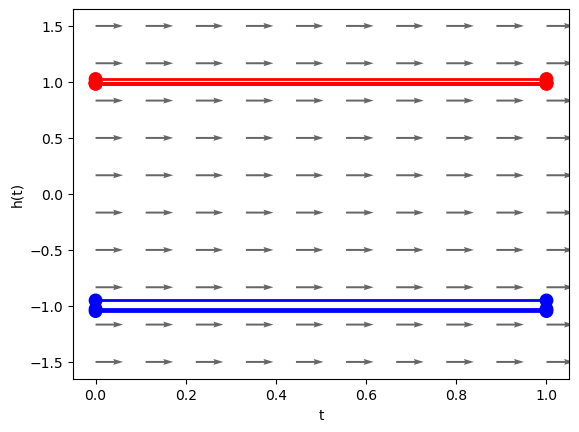

In [84]:
# Visualize ODE plot with training
# Hack to get some example trajectories to explore. 
for inputs, targets in testData:
    inputs = inputs.to(neuralODE.device)
    targets = targets.to(neuralODE.device)
    break
    
# Use the inner MLP to plot
vector_field_plt(neuralODE.MLPNeuralODE, num_points=10, timesteps=10, inputs=inputs[:8], targets=targets[:8],
                 h_min=-1.5, h_max=1.5, model=neuralODE)

In [85]:
# Load the HARD dataset.

x_train = np.load("datasets/x_train_ode_hard.npy")
x_test = np.load("datasets/x_test_ode_hard.npy")
y_train = np.load("datasets/y_train_ode_hard.npy")
y_test = np.load("datasets/y_test_ode_hard.npy")

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [86]:
# Train a neural ODE. Choose your parameters. 
neuralODE = trainer(neuralODE, trainData, testData, learning_rate, step_size, epochs, output_rate=100, problem_type="NeuralODE")

0 4.0320548094235935 4.012750744819641
100 1.0075692717845623 1.0137287080287933
200 1.0074854676540081 1.0093713402748108
300 1.0066724052795997 1.007950022816658
400 1.0072840681442847 1.007728859782219
500 1.0070303082466125 1.0121996849775314
600 1.007216568176563 1.013292357325554
700 1.0065453190069933 1.0104736387729645
800 1.0065410733222961 1.0113796591758728
900 1.007160315146813 1.010056048631668
1000 1.0075602118785565 1.0111346542835236
1100 1.006946297792288 1.0107192993164062
1200 1.0073397342975323 1.0109337866306305
1300 1.006665445291079 1.0114657580852509
1400 1.007683983215919 1.0101654380559921
1500 1.006322938662309 1.0115234106779099
1600 1.0072622986940236 1.0110897719860077
1700 1.0064540276160607 1.0110327452421188
1800 1.0072780159803538 1.0116610825061798
1900 1.0077364582281847 1.011642336845398


In [87]:
# This test is supposed to fail to show you that the Neural ODE doesn't work! It should FAIL. 
test_model(trainData, neuralODE, 1e-4, problem_type="NeuralODE")

TEST FAILED


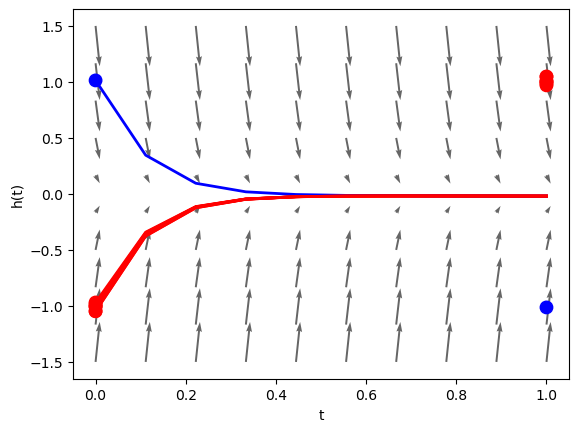

In [88]:
# Visualize ODE plot with training with 10 trajectories
for inputs, targets in testData:
    inputs = inputs.to(neuralODE.device)
    targets = targets.to(neuralODE.device)
    break
    
# Use the inner MLP to plot
vector_field_plt(neuralODE.MLPNeuralODE, num_points=10, timesteps=10, inputs=inputs[:8], targets=targets[:8],
                 h_min=-1.5, h_max=1.5, model=neuralODE)

### <font size='4' color='orange'>Task 2.3: Implement a Augmented Neural ODE (5 points)</font> 

We see that the trajectory does not result in a viable result. How to fix this? Augmented neural ODEs!
Modify your neural ODE class to be an augmented neural ODE.

In [172]:
# A augmented ODE layer

class AugmentedNeuralODEBlock(nn.Module):
    # nueral_ode_model: Contains the neural network model to use for \dot{x} = f(x) 
    # tolerance: Controls the tolerance of the ODE solver
    # max_steps: The max number of ODE solver steps to take
    def __init__(self, neural_ode_model, tolerance, max_steps):
        super(AugmentedNeuralODEBlock, self).__init__()
        # Your code goes here. 
        self.ode_model = neural_ode_model
        self.tolerance = tolerance
        self.max_steps = max_steps
        
    # times: Controls the times at which the neural ODE is evaluated at 
    # Only returns the final time at t=T. 
    def forward(self, times, x):
        if times is None:
            times = torch.tensor([0, 1], device=x.device).float().type_as(x)
        else:
            times = times.to(x.device)
        # Your code goes here. 
        aug = torch.zeros(x.shape[0], 1).to(x.device)
        x_aug = torch.cat([x, aug], dim=1)
        out = odeint(self.ode_model, x_aug, times,
                     rtol=self.tolerance,
                     atol=self.tolerance,
                     method="dopri5",
                     options={'max_num_steps': self.max_steps})
        return out[-1]

    # Returns the entire trajecotry with timesteps discretization    
    def trajectory(self, timesteps, x):
        times = torch.linspace(0, 1, timesteps, device=x.device)
        # Your code goes here. 
        aug = torch.zeros(x.shape[0], 1).to(x.device)
        x_aug = torch.cat([x, aug], dim=1)
        out = odeint(self.ode_model, x_aug, times.to(x.device), 
                     rtol=self.tolerance, 
                     atol=self.tolerance, 
                     method="dopri5", 
                     options={'max_num_steps': self.max_steps})
        return out
        
# A full augmented neural ODE. Build a augmented neural ODE with a MLP as its base.

class AugmentedNeuralODE(nn.Module):
    # num_layers: The number of layers in the MLP of the neural ODE.
    # input_dim: Input dimension of the data.
    # hidden_dims: An array containing the hidden dimensions for the MLP of the neural ODE.  
    # output_dim: Output dimension of the data. 
    # activation_func: A torch activation function used for the nonlinearity. 
    # tolerance: Tolerance for the ODE solver
    # max_steps: Max steps for the ODE solver
    def __init__(self, num_layers, input_dim, hidden_dims, output_dim, activation_func, tolerance, max_steps):
        super(AugmentedNeuralODE, self).__init__()
        # Your code goes here. 
        self.ode_model = MLP(num_layers=num_layers,
                        input_dim=input_dim + 1,
                        hidden_dims=hidden_dims,
                        output_dim=output_dim + 1,
                        activation_func=activation_func)
        self.block = AugmentedNeuralODEBlock(self.ode_model, tolerance, max_steps)
    # times: The integration times. Can be set to $[0, 1]$ for this exercise. 
    def forward(self, times=None, x=None):
        # Your code goes here. 
        return self.block(times, x)
        
    def trajectory(self, timesteps=None, x=None):
        # Your code goes here. 
        return self.block.trajectory(timesteps, x)

In [174]:
# Training loop modification

# Model: pass the model to be trained
# trainData: pass the training data
# testData: pass the testing data
# learning_rate: pass the initial learning rate
# step_size: pass the initial step size for the learning rate scheduler
def augmented_trainer(model, trainData, testData, learning_rate, step_size, epochs, output_rate):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)
    loss = torch.nn.MSELoss()
    for ep in range(epochs):
        model.train()
        train_loss = 0
        for x_vals, y_vals in trainData:
            x_vals, y_vals = x_vals.to(model.device), y_vals.to(model.device)
            optimizer.zero_grad()
            out = model(x=x_vals)
            aug = torch.zeros(y_vals.shape[0], y_vals.shape[1], device=y_vals.device)
            y_vals = torch.cat([y_vals, aug], 1)
            lp = loss(out, y_vals)
            lp.backward()
                
            optimizer.step()
            train_loss += lp.item()
    
        scheduler.step()
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x_vals, y_vals in testData:
                x_vals, y_vals = x_vals.to(model.device), y_vals.to(model.device)
                out = model(x=x_vals)
                aug = torch.zeros(y_vals.shape[0], y_vals.shape[1], device=y_vals.device)
                y_vals = torch.cat([y_vals, aug], 1)
    
                test_loss += loss(out, y_vals).item()
        train_loss /= len(trainData)
        test_loss /= len(testData)
        if ep%output_rate == 0:
                print(ep, train_loss, test_loss)
    return model

In [176]:
# Train a neural ODE. 
# Code goes here. 
augemntedNeuralODE = AugmentedNeuralODE(
    num_layers=3,
    input_dim=1,
    hidden_dims=[128, 128],
    output_dim=1,
    activation_func=nn.Tanh(),
    tolerance=1e-3,
    max_steps=1000
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
augemntedNeuralODE = augemntedNeuralODE.to(device)
augemntedNeuralODE.device = device
augemntedNeuralODE.MLPNeuralODE = augemntedNeuralODE.ode_model

# Create a augmented Neural ODE with variable name augmentedNeuralODE
augemntedNeuralODE = augmented_trainer(augemntedNeuralODE, trainData, testData, learning_rate, step_size, epochs, output_rate= 100)

0 0.00196105914974396 0.00011522124883153342
100 6.205129332581549e-10 8.174047074126025e-10
200 1.6838406474706247e-10 1.5529855576116144e-10
300 2.2687595244597503e-14 2.1372157690210998e-14
400 2.3800780051212842e-14 3.984341460935265e-15
500 2.9864124000452535e-14 9.505811519949508e-15
600 3.8608619136481536e-13 8.40246412796757e-14
700 1.8684809333303e-12 2.1598655403869722e-12
800 1.2862021753781923e-13 4.806263584047502e-14
900 1.0226283903881638e-12 1.8646732533540908e-12
1000 1.844037323149106e-13 4.0901771386523294e-14
1100 1.1013915433432005e-13 1.0215937563901441e-13
1200 5.007750650819784e-14 6.784731003393984e-15
1300 1.6222549189669634e-13 5.95629497910889e-14
1400 3.8828047171929207e-14 1.2927521631071178e-14
1500 3.724305008473753e-14 6.373703764363743e-14
1600 1.4751009137619882e-14 1.4963713571342918e-14
1700 8.715385353783456e-15 9.672504881363253e-15
1800 1.7780974315440023e-14 9.442969177555057e-14
1900 7.0931289347211435e-15 2.850638586208454e-14


In [177]:
def test_model_augmented(testData, model, tol):
    model.eval()
    loss = torch.nn.MSELoss()
    with torch.no_grad():
        test_loss = 0
        for x_vals, y_vals in testData:
            x_vals, y_vals = x_vals.to(model.device), y_vals.to(model.device)
            out = model(None, x_vals)
            aug = torch.zeros_like(y_vals)
            y_vals = torch.cat([y_vals, aug], 1)
    
            test_loss += loss(out, y_vals).item()
        test_loss /= len(testData)
    if(test_loss <= tol):
        print("TEST PASSED")
    else:
        print("TEST FAILED")
        
test_model_augmented(testData, augemntedNeuralODE, 1e-4)

TEST PASSED


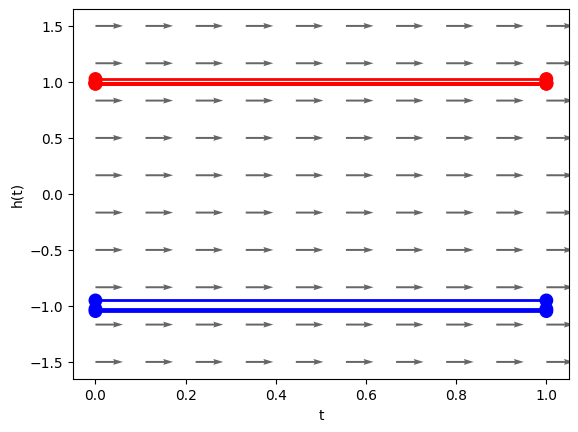

In [178]:
# Visualize ODE plot with training
for inputs, targets in testData:
    inputs = inputs.to(augemntedNeuralODE.device)
    targets = targets.to(augemntedNeuralODE.device)
    break
    
# Use the inner MLP to plot
vector_field_plt(augemntedNeuralODE.MLPNeuralODE, num_points=10, timesteps=10, inputs=inputs[:8], targets=targets[:8],
                 h_min=-1.5, h_max=1.5, model=augemntedNeuralODE, augmented=True)

### <font size='4' color='orange'>Task 2.4 Discussion (15 points)</font> 

Answer the following questions in markdown in the 3 cells below:

### <font size='3' color='blue'> Give an interpretation of this vector field and what you make of it. What would be a better way to plot it? </font>

This vector field shows how the hidden state changes over time, as learned by the augmented neural ODE. The arrows represent the direction and speed of state evolution at each point. The red and blue trajectories stay clearly separated, meaning the model has learned a flow that can distinguish different input classes; This is a successful vector field—different classes evolve along distinct paths, leading to correct classification; As for a better way to plot it, I think we can add a color gradient to show time along each trajectory, highlight starting and ending points more clearly, and even animate the trajectories to show how points move over time!

### <font size='3' color='blue'> Why does the augmented Neural ODE work? Discuss the pros and cons of this approach </font>

Augmented Neural ODE works because it adds extra dimensions to the hidden state. This gives the model more space to separate data that can’t be separated in the original space. Pros: It is more expressive, which can model complex flows and decision boundaries; It can fix failure cases of normal Neural ODEs as shown above; It can also enable better class separation and improves accuracy. Cons: Extra dimensions result in higher computational cost; It might be overfitting if augmentation is too large.

### <font size='3' color='blue'> You made a series of design decisions at each step from the MLP to Neural ODE.  Discuss these decisions including your choice of paramters and what fundamental ideas in ML influenced your choices (bias/variance tradeoff, regularization, etc.) </font>

1. I used a 3-layer MLP with hidden dimensions [128, 128], which provides enough capacity to fit nonlinear functions without severe overfitting. This reflects the bias/variance tradeoff — shallow models underfit, while deep models may overfit.
2. For activation function, I chose Tanh instead of ReLU because smoother activations help the ODE solver better approximate continuous trajectories, especially important in Neural ODEs.
3. For the learning rate and optimizer: I used Adam with a learning rate of 5e-4 both emprically and with multiple testing. This supports stable convergence while avoiding oscillations.
4. I also set the tolerance to 1e-3 to balance speed and accuracy during ODE integration.
5. Last but not least, in augmented Neural ODE, I added 1 extra dimension, increasing the model’s capacity to separate data that standard Neural ODEs could not.

### Question 3 (10 points total): Simulate your finite difference scheme 
1. Simulate your finite difference scheme as before.

### <font size='4' color='orange'>Task 3.5/3.6 Burger's equation (10 points)</font>  
Implement your derived finite differencing scheme for the Burger's equation in the written section. There are two tasks here. 

1. Implement the initial condition and visualize it. (5pts)
2. Implement the finite differencing scheme. (5pts)

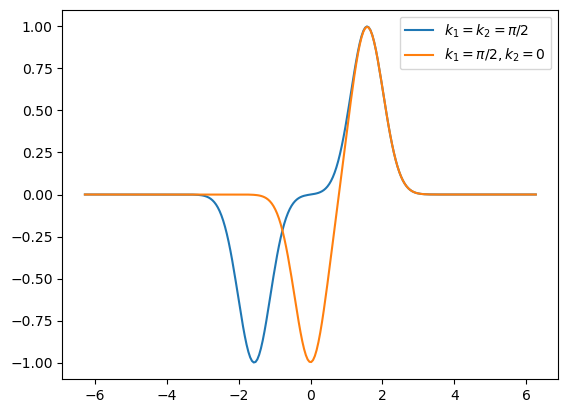

In [122]:
# Show initial conditions for reference
T = 5
X = 2*math.pi # -2pi, 2pi
dx = 0.05
dt = 0.01
x = np.arange(-X, X, dx)
t = np.arange(0, T, dt)

def phi(x, k1, k2, nu):
    # Your code goes here. 
    first_term = np.exp(-((x - k1) ** 2) / (4 * nu))
    second_term = np.exp(-((x + k2) ** 2) / (4 * nu))
    return first_term - second_term
    
def gen_initial_condition(x, k1, k2, nu):
    init_cond = np.zeros((len(x)))
    for i in range(len(x)):
        init_cond[i] = phi(x[i], k1, k2, nu)
    return init_cond

k11 =math.pi/2
k12 = math.pi/2
k21 = math.pi/2
k22 = 0
nu = 0.1

u1 = gen_initial_condition(x, k11, k12, 0.1)
u2 = gen_initial_condition(x, k21, k22, 0.1)

plt.plot(x, u1, label=r"$k_1=k_2=\pi/2$")
plt.plot(x, u2, label=r"$k_1=\pi/2, k_2=0$")
plt.legend()
plt.savefig("initCond.pdf")

### Comment on the initial condition shape:

1. When $k_1 = k_2 = \frac{\pi}{2}$, the two Gaussian terms in $\phi(x, k_1, k_2)$ are symmetric around the origin. The resulting function is anti-symmetric, with a negative peak on the left and a positive peak on the right. The shape is balanced and centered at $x = 0$.

2. When $k_1 \gg k_2$ (e.g., $k_1 = \frac{\pi}{2},\ k_2 = 10^{-2}$), the left Gaussian becomes near the origin, while the right Gaussian centered further away. This causes the two components to be unbalanced. The result is an asymmetric waveform.


In [125]:
# Implement finite differencing scheme. 
# u is a function of two variables, t and x. Use vectorized python for speeding up your calculations
def simulate_pde(init_cond, x, t, nu):
    u = np.zeros((len(t), len(x)))
    u[0] = init_cond
    nx = len(x)
    for i in range(1, len(t)):
        # Your code goes here. 
        u_n = u[i-1]

        u_x = (u_n[1:] - u_n[:-1]) / dx
        u_xx = (u_n[2:] + u_n[:-2] - 2 * u_n[1:-1]) / dx**2

        u[i, 1:-1] = u_n[1:-1] - dt * u_n[1:-1] * u_x[:-1] + dt * nu * u_xx

        u[i, 0] = 0
        u[i, -1] = 0
    return u

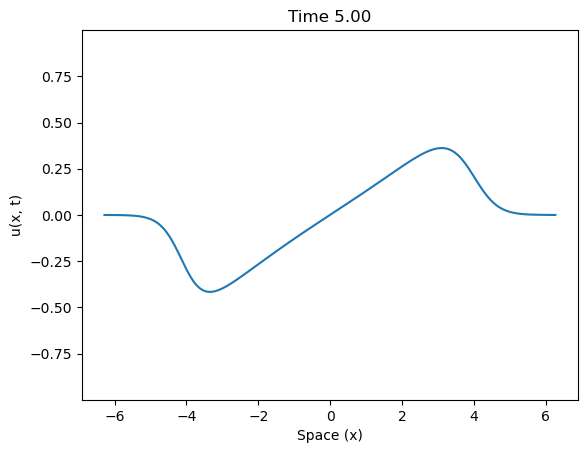

In [127]:
# Quick animation to confirm correctness. 
T = 5
X = 2*math.pi # -2pi, 2pi
dx = 0.05
dt = 0.01
x = np.arange(-X, X, dx)
t = np.arange(0, T, dt)
nu = 0.1
init_cond = gen_initial_condition(x, math.pi/2, math.pi/2, 0.1)
u = simulate_pde(init_cond, x, t, nu)

fig, ax = plt.subplots()
line, = ax.plot(x, u[0])
ax.set_ylim(np.min(u), np.max(u))
ax.set_xlabel("Space (x)")
ax.set_ylabel("u(x, t)")
ax.set_title("PDE Evolution Over Time")

def update(frame):
    line.set_ydata(u[frame])
    ax.set_title(f"Time {frame / (len(t)-1) * T:.2f}") 
    return line,

ani = animation.FuncAnimation(fig, update, frames=len(t), blit=True, interval=50)

# Save as MP4
# For those with FFMPEG installed (or can install)
ani.save("pde_simulation.mp4", writer="ffmpeg", fps=20)

# Display in Jupyter
Video("pde_simulation.mp4")

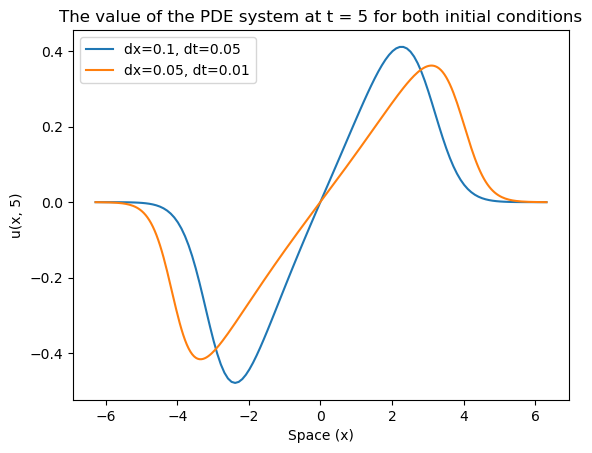

In [128]:
# Plot final values here (hint use initial condition plotting format)
# Parameters
T = 5
X = 2 * math.pi
k1 = math.pi / 2
k2 = math.pi / 2
nu = 0.1

dx1 = 0.1
dt1 = 0.05
x1 = np.arange(-X, X + dx1, dx1)
t1 = np.arange(0, T + dt1, dt1)
u0_1 = gen_initial_condition(x1, k1, k2, nu)
sol1 = simulate_pde(u0_1, x1, t1, nu)

dx2 = 0.05
dt2 = 0.01
x2 = np.arange(-X, X + dx2, dx2)
t2 = np.arange(0, T + dt2, dt2)
u0_2 = gen_initial_condition(x2, k1, k2, nu)
sol2 = simulate_pde(u0_2, x2, t2, nu)

plt.plot(x1, sol1[-1], label="dx=0.1, dt=0.05")
plt.plot(x2, sol2[-1], label="dx=0.05, dt=0.01")
plt.title(r"The value of the PDE system at t = 5 for both initial conditions")
plt.xlabel("Space (x)")
plt.ylabel("u(x, 5)")
plt.legend()
plt.show()


In [129]:
def test_pde(u):
    random.seed(2025)
    correctVals = [0.225416533670257, 0.28684150441306727, -0.023018737475055662, -0.028658515488043945, 0.0, 5.60471735663635e-09, 0.2410662271322244, -1.319802220742373e-06, -0.4342028102527246, -8.871369766002773e-13]
    for i in range(10):
        xval = random.randint(0, len(x))
        tval = random.randint(0, len(t))
        assert(abs(u[tval, xval]-correctVals[i]) < 1e-5)
    print("TEST PASSED")

test_pde(u)

TEST PASSED


### Question 4 (25 points total): Build out and explore a neural operator
1. Answer Q4.1 
2. Build out a Fourier Neural Operator (10 pts, Use torch. Feel free to make your own design decisions. Activation function, number of layers, etc. You will defend these design decisions later.)
3. Using your solver, analyze the qualities of FNO. Consider different training and testing methdologies and how do the errors change. 
4. Add a phyiscs informed loss to your FNO. Does your result improve?  (5pts)
We provide a template for each type of problem and ask that you don't modify the parameter inputs and outputs for testing. However, the methods can be implemented however you choose! (5pts)

<font size='4' color='orange'> Task 4.2 Designing an FNO (10 points) </font>  
We have provided the boiler plate code for you to design the FNO. It is your job to implement two classes:
- The spectral convolution class which computes the FFT, performs weight multiplication, and computes the IFFT. </li>
- The FNO class which combines the spectral convolution layers together with the lifting and projection MLPs to make an FNO. </li>

Now that we have designed our FNO, it is time to experiment. In particular, you will explore 2 key properties of FNO. 
- The super resolution property
- The effect of introducing a PINN loss

In [89]:
# In_channels: Then number of inputs in the FFT
# Out_channels: The number of outputs for the FFT. 
# modes: The number of Fourier modes to keep - at most floor(N/2)+1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class SpectralConv(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        # Setup your input and output channels
        super(SpectralConv, self).__init__()
        # Code goes here
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        # Setup weight matrix with scaling (we do this for you)
        self.scale = 1 / (self.in_channels*self.out_channels)
        self.weights = nn.Parameter(self.scale*torch.randn(in_channels, out_channels, self.modes, dtype=torch.cfloat))

    # Input is of the form (batch_size, dim_size, input_channel)
    def forward(self, x):
        # batchsize = x.shape[0]
        # Code goes here
        B, N, _ = x.shape
        
        # Perform's the FFT
        x_ft = torch.fft.rfft(x, dim=1, norm='ortho')  # (batch, in_channel, N_freq)
        n_freq = x_ft.shape[-1]
        
        # Multiply by weight matrix in Fourier Space (Hint: Use Einsum and use only the first self.modes values
        # of both x_fourier in the multiplication. Hence, only need to set first self.modes of out_fourier)
        N_fft = x_ft.size(1)
        out_ft = torch.zeros(B, N_fft, self.out_channels, 
                             dtype=torch.cfloat, device=x.device)

        x_slice = x_ft[:, :self.modes, :]
        x_slice = x_slice.permute(0, 2, 1)

        out_slice = torch.einsum('bcs, ios -> bos', x_slice, self.weights)
        out_ft[:, :self.modes, :] = out_slice.permute(0, 2, 1)
        
        # Perform's the IFFT
        x = torch.fft.irfft(out_ft, n=N, dim=1, norm='ortho')
        return x        

In [90]:
# Fourier Neural Operator:
# 1. First, lifts the input to the target width
# 2. Comutes num_layers of spectral convolution and skip convolutions
# 3. Projects back down to output_size
class FNO(nn.Module):
    def __init__(self, modes, width, num_layers, input_size, output_size, activation_func):
        # modes: The number of Fourier modes to keep 
        # width: The numeber of Neurons in each layer
        # num_layers: The number of FNO layers
        # input_size: The starting input size to lift from. Should be set to 1 
        # output_size: The output size to project to. Should be set to 1
        # Setup your parameters here
        super(FNO, self).__init__()
        # Code goes here
        self.modes = modes
        self.width = width
        self.num_layers = num_layers
        self.input_size = input_size
        self.output_size = output_size

        # Setup your neural networks here. Recall, you need:
        # lifting_layer: takes input_size+1 since you append the grid locations to width
        # projection_layer: takes width to output_size
        # Module list of spectral convolutions with modes specified
        # Module list of regular 1d convolutional nets.
        # Activation function for all layers
        # Code goes here
        self.lifting_layer = nn.Linear(input_size + 1, width)
        self.projection_layer = nn.Linear(width, output_size)
        self.spectral_layers = nn.ModuleList([SpectralConv(width, width, modes) for _ in range(num_layers)])
        self.skip_layers = nn.ModuleList([nn.Conv1d(width, width, 1) for _ in range(num_layers)])
        self.activation = activation_func
        
    def forward(self, x, grid):
        # Forward pass. Needs to do the following:
        # 1. Concat x and the grid on last dimension
        # 2. Lift the values (be careful here, one needs to permute after lifting
        # to make sure the input is correct for the conolutional layers)
        # 3. Pass x to both spectral and skips and add.
        # 4. Apply activation and repeat 3, 4 num_layers times
        # 5. Project back (don't forget to permute before)
        
        # input shape: (batchsize, num_x, input_size)
        # output shape: (batch_size, num_x, output_size)
        
        # Code goes here
        x = torch.cat([x, grid], dim=-1)  # (batchsize, num_x, input_size+1)
        
        x = self.lifting_layer(x)  # (batchsize, num_x, width)
        x = x.permute(0, 2, 1)     # (batchsize, width, num_x)
        # print(f"x shape: {x.shape}")
        
        for i in range(self.num_layers):
            x1 = self.spectral_layers[i](x.permute(0, 2, 1))
            x1 = x1.permute(0, 2, 1)
            x2 = self.skip_layers[i](x)
            
            x = x1 + x2
            x = self.activation(x)
            
        x = x.permute(0, 2, 1)
        x = self.projection_layer(x)
        # x = self.activation(x)
        return x


In [95]:
# Compile your FNO here with a set of parameters (Hint: GeLU works 
# really well for the activation) 
modes = 16
width = 32
num_layers = 4
input_size = 1
output_size = 1

modelCoarse = FNO(
    modes=modes,
    width=width,
    num_layers=num_layers,
    input_size=input_size,
    output_size=output_size,
    activation_func= nn.GELU()
)

modelRefined = FNO(
    modes=modes,
    width=width,
    num_layers=num_layers,
    input_size=input_size,
    output_size=output_size,
    activation_func=nn.GELU()
)

<font size='4' color='orange'> Q4.3 Super resolution property (5 points) </font>  
To begin, we will explore the super resolution property by comparing two experiments. First, we will train on a coarse dataset and test on a super fine dataset, and then we will perform the opposite (as a sub-resolution exploration) and compare.  

In [97]:
# Setup parameters
epochs = 300
batch_size = 8
learning_rate = 1e-3
step_size = 100

# Load the dataset. 
x_train = np.load("datasets/coarse_burgers_inputs_train.npy").astype(np.float32)
x_test = np.load("datasets/coarse_burgers_inputs_test.npy").astype(np.float32)
y_train = np.load("datasets/coarse_burgers_outputs_train.npy").astype(np.float32)
y_test = np.load("datasets/coarse_burgers_outputs_test.npy").astype(np.float32)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

# Create Tensor Datasets
trainDataCoarse = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testDataCoarse = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

# Load the dataset.
x_train = np.load("datasets/refined_burgers_inputs_train.npy").astype(np.float32)
x_test = np.load("datasets/refined_burgers_inputs_test.npy").astype(np.float32)
y_train = np.load("datasets/refined_burgers_outputs_train.npy").astype(np.float32)
y_test = np.load("datasets/refined_burgers_outputs_test.npy").astype(np.float32)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

# Create Tensor Datasets
trainDataRefined = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testDataRefined = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [98]:
# Build out the grid for the coarse data
def get_grid(x):
    nx = x.shape[1]
    batch_size = x.shape[0]
    gridx = torch.tensor(np.linspace(-2*math.pi, 2*math.pi, nx), dtype=torch.float)
    gridx = gridx.reshape(1, nx, 1).repeat([batch_size, 1, 1])
    return gridx

In [99]:
# Model: pass the model to be trained
# trainData: pass the training data
# testData: pass the testing data
# learning_rate: pass the initial learning rate
# step_size: pass the initial step size for the learning rate scheduler
# epochs: number of epochs to train for
# output_rate: How often to print
# grid: FNO grid
def train_fno(model, trainData, testData, learning_rate, step_size, epochs, output_rate):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)
    loss = torch.nn.MSELoss()
    test_loss_arr = []
    train_loss_arr = []
    print("Epoch number", "Epoch Time", "Avg. Train Loss", "Avg. Test Loss")
    print("Average is last \"output_rate\" values")
    for ep in range(epochs):
        start_time = time.time()
        model.train()
        train_loss = 0
        for x_vals, y_vals in trainData:
            optimizer.zero_grad()
            out = model(x=x_vals, grid=get_grid(x_vals))
            # print("out min/max", out.min().item(), out.max().item())
            # print("y min/max", y_vals.min().item(), y_vals.max().item())        
            lp = loss(out, y_vals)
            # print("loss", lp.item())
            lp.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
     
            optimizer.step()
            train_loss += lp.item()
    
        scheduler.step()
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x_vals, y_vals in testData:
                out = model(x=x_vals, grid=get_grid(x_vals))
    
                test_loss += loss(out, y_vals).item()
        train_loss /= len(trainData)
        test_loss /= len(testData)
        test_loss_arr.append(test_loss)
        train_loss_arr.append(train_loss)
        if ep%output_rate == 0:
                print(ep, time.time()-start_time, np.mean(train_loss_arr[-output_rate:]), np.mean(test_loss_arr[-output_rate:]))
    return model

In [100]:
modelCoarse = train_fno(modelCoarse, trainDataCoarse, testDataCoarse, learning_rate, step_size, epochs, output_rate = 50)

Epoch number Epoch Time Avg. Train Loss Avg. Test Loss
Average is last "output_rate" values
0 1.857966423034668 0.003688255136686303 0.0009153739699216273
50 1.9656598567962646 0.00025746367523577776 0.00033994776033908304
100 1.6676619052886963 0.00018368410739559755 0.0002208796497115355
150 1.631847620010376 9.168128576329278e-05 0.00010136198226973648
200 1.940519094467163 0.000102449847746574 0.00012100368950856277
250 1.7822492122650146 5.355110203596365e-05 4.570771780121364e-05


In [101]:
modelRefined = train_fno(modelRefined, trainDataRefined, testDataRefined, learning_rate, step_size, epochs, output_rate = 50)

Epoch number Epoch Time Avg. Train Loss Avg. Test Loss
Average is last "output_rate" values
0 2.901209831237793 0.0045749809720710055 0.004082219066241613
50 3.495384931564331 0.0002614310058216905 0.00028742462752583933
100 3.267967462539673 0.00020769694103944106 0.00022527047035020167
150 3.223017454147339 8.797458050533921e-05 9.011321811787917e-05
200 3.3532068729400635 8.849010249051929e-05 9.166530224040169e-05
250 3.323608636856079 4.579126052752232e-05 4.908751204801285e-05


In [163]:
torch.save(modelRefined.state_dict(), "modelRefined")
torch.save(modelCoarse.state_dict(), "modelCoarse")

In [165]:
# Models should achieve a test error of <3e-4
def test_model_fno(testData, model, tol):
    model.eval()
    loss = torch.nn.MSELoss()
    with torch.no_grad():
        test_loss = 0
        for x_vals, y_vals in testData:
            out = model(x_vals, grid=get_grid(x_vals))
    
            test_loss += loss(out, y_vals).item()
        test_loss /= len(testData)
    if(test_loss <= tol):
        print("TEST PASSED")
    else:
        print("TEST FAILED")

def get_test_loss_fno(testData, model):
    model.eval()
    loss = torch.nn.MSELoss()
    with torch.no_grad():
        test_loss = 0
        for x_vals, y_vals in testData:
            out = model(x_vals, grid=get_grid(x_vals))
    
            test_loss += loss(out, y_vals).item()
        test_loss /= len(testData)
        print(test_loss)

In [104]:
test_model_fno(testDataCoarse, modelCoarse, 3e-4)

TEST PASSED


In [105]:
test_model_fno(testDataRefined, modelRefined, 3e-4)

TEST PASSED


#### Experiment quantitatively with sub and super resolution of both trained models!

In [107]:
print("FNO Coarse with Coarse Dataset", get_test_loss_fno(testDataCoarse, modelCoarse))
print("FNO Refined with Coarse Dataset", get_test_loss_fno(testDataCoarse, modelRefined))
print("FNO Coarse with Refined Dataset", get_test_loss_fno(testDataRefined, modelCoarse))
print("FNO Refined with Refined Dataset", get_test_loss_fno(testDataRefined, modelRefined))

5.581962586102936e-05
FNO Coarse with Coarse Dataset None
7.86174812394445e-05
FNO Refined with Coarse Dataset None
0.00015077041378110432
FNO Coarse with Refined Dataset None
2.7985007154012026e-05
FNO Refined with Refined Dataset None


#### Now lets visualize the solutions and compare the super resolution errors. To do this, lets generate a test example. 

In [133]:
# Get our ground truth examples
T = 5
X = 2*math.pi # -2pi, 2pi
dx = 0.1
dt = 0.001
x = np.arange(-X, X, dx)
t = np.arange(0, T, dt)
nu = 0.5
init_cond_coarse = gen_initial_condition(x, math.pi/2, math.pi/2, nu).astype(np.float32)
u_coarse = simulate_pde(init_cond_coarse, x, t, nu).astype(np.float32)

T = 5
X = 2*math.pi # -2pi, 2pi
dx = 0.02
dt = 0.0001
x = np.arange(-X, X, dx)
t = np.arange(0, T, dt)
nu = 0.5
init_cond_refined = gen_initial_condition(x, math.pi/2, math.pi/2, nu).astype(np.float32)
u_refined = simulate_pde(init_cond_refined, x, t, nu).astype(np.float32)

In [135]:
# Convert into form for PDE
input_coarse_example = torch.tensor(init_cond_coarse).reshape(1, len(init_cond_coarse), 1)
output_coarse_example = torch.tensor(u_coarse[-1]).reshape(1, len(init_cond_coarse), 1)

input_refined_example = torch.tensor(init_cond_refined).reshape(1, len(init_cond_refined), 1)
output_refined_example = torch.tensor(u_refined[-1]).reshape(1, len(init_cond_refined), 1)

In [137]:
# Test models
with torch.no_grad():
    output_coarse_model_coarse = modelCoarse(input_coarse_example, get_grid(input_coarse_example))
    output_coarse_model_refined = modelCoarse(input_refined_example, get_grid(input_refined_example))

    output_refined_model_coarse = modelRefined(input_coarse_example, get_grid(input_coarse_example))
    output_refined_model_refined = modelRefined(input_refined_example, get_grid(input_refined_example))

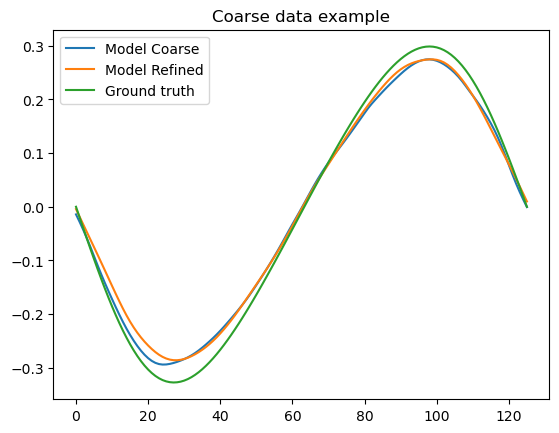

In [139]:
plt.plot(output_coarse_model_coarse.flatten(), label="Model Coarse")
plt.plot(output_refined_model_coarse.flatten(), label="Model Refined")
plt.plot(u_coarse[-1], label="Ground truth")
plt.title("Coarse data example")
plt.legend()

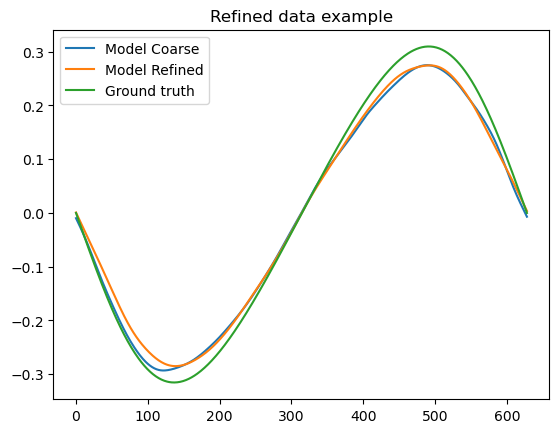

In [141]:
plt.plot(output_coarse_model_refined.flatten(), label="Model Coarse")
plt.plot(output_refined_model_refined.flatten(), label="Model Refined")
plt.plot(u_refined[-1], label="Ground truth")
plt.title("Refined data example")
plt.legend()

### <font size='3' color='blue'> Briefly comment on your performance both qualatatively and quantitatively. Is it as expected? </font>

#### **Qualitatively**
- Both models capture the global wave shape accurately.
- Coarse-trained model (blue curve) is smoother and slightly underestimates curvature near peaks.
- Refined-trained model (orange curve) matches sharper features better, especially on fine grid.

#### **Quantitatively**
- Refined-trained model achieves the lowest error on refined data, as expected.
- Coarse-trained model generalizes well to refined inputs, showing super-resolution ability.
- Both models are close to ground truth, with the refined model slightly more accurate overall.

<font size='4' color='orange'> Q4.4 PINN Loss (5 points) </font>  
We will now repeat the experiments above, but with the introduction of a PINN loss on the boundary conditions. This is a super simple example of a PINN loss as all we are including is the boundary points. One could augment this significantly, by forceing the model to obey the Burger's equation, but this would require time-dependence.

In [143]:
# Model: pass the model to be trained
# trainData: pass the training data
# testData: pass the testing data
# learning_rate: pass the initial learning rate
# step_size: pass the initial step size for the learning rate scheduler
# epochs: number of epochs to train for
# output_rate: How often to print
# grid: FNO grid
def train_fno_bc_loss(model, trainData, testData, learning_rate, step_size, epochs, output_rate):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)
    loss = torch.nn.MSELoss()
    test_loss_arr = []
    train_loss_arr = []
    print("Epoch number", "Epoch Time", "Avg. Train Loss", "Avg. Test Loss")
    print("Average is last \"output_rate\" values")
    for ep in range(epochs):
        start_time = time.time()
        model.train()
        train_loss = 0
        for x_vals, y_vals in trainData:
            optimizer.zero_grad()
            out = model(x=x_vals, grid=get_grid(x_vals))

            # ADD PINN LOSS HERE
            lp = loss(out, y_vals) + 0.5*torch.mean(torch.abs(out[:, 0]) )+ 0.5*torch.mean(torch.abs(out[:, -1]))
            lp.backward()
                
            optimizer.step()
            train_loss += lp.item()
    
        scheduler.step()
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x_vals, y_vals in testData:
                out = model(x=x_vals, grid=get_grid(x_vals))
    
                test_loss += loss(out, y_vals).item()
        train_loss /= len(trainData)
        test_loss /= len(testData)
        test_loss_arr.append(test_loss)
        train_loss_arr.append(train_loss)
        if ep%output_rate == 0:
                print(ep, time.time()-start_time, np.mean(train_loss_arr[-output_rate:]), np.mean(test_loss_arr[-output_rate:]))
    return model

In [145]:
modelCoarsePINN = FNO(
    modes=16,          
    width=32,               
    num_layers=4,           
    input_size=1,           
    output_size=1,          
    activation_func=nn.GELU()
)

modelCoarsePINN = train_fno_bc_loss(modelCoarsePINN, trainDataCoarse, testDataCoarse, learning_rate, step_size, epochs, output_rate=50)

Epoch number Epoch Time Avg. Train Loss Avg. Test Loss
Average is last "output_rate" values
0 1.7011301517486572 0.05509189686704988 0.004963403442301429
50 1.8400764465332031 0.002744899874909027 0.0014116963519056577
100 2.455223798751831 0.01786666729166049 0.01692780021076592
150 2.648390769958496 0.016213594440502667 0.01692472943606285
200 1.9753754138946533 0.00849965431737063 0.017874397281663665
250 2.1419589519500732 0.00014760462377487994 0.00012181508185536725


In [146]:
modelRefinedPINN = FNO(
    modes=16,
    width=32,
    num_layers=4,
    input_size=1,
    output_size=1,
    activation_func=nn.GELU()
)

modelRefinedPINN = train_fno_bc_loss(modelRefinedPINN, trainDataRefined, testDataRefined, learning_rate, step_size, epochs, output_rate=50)

Epoch number Epoch Time Avg. Train Loss Avg. Test Loss
Average is last "output_rate" values
0 3.380824565887451 0.0342450973833293 0.004701126348943665
50 2.903930902481079 0.0013381490923373637 0.0004484716656196934
100 2.996147394180298 0.014735757038816275 0.014318292616763548
150 4.6528849601745605 0.016211324310160976 0.017354642056788393
200 3.776991367340088 0.01621128451009075 0.01735461197077082
250 5.944181680679321 0.016573969490611844 0.01735460994908443


In [147]:
print("FNO Coarse with Coarse Dataset", get_test_loss_fno(testDataCoarse, modelCoarsePINN))
print("FNO Refined with Coarse Dataset", get_test_loss_fno(testDataCoarse, modelRefinedPINN))
print("FNO Coarse with Refined Dataset", get_test_loss_fno(testDataRefined, modelCoarsePINN))
print("FNO Refined with Refined Dataset", get_test_loss_fno(testDataRefined, modelRefinedPINN))

0.00013441763383945308
FNO Coarse with Coarse Dataset None
0.016925083759885568
FNO Refined with Coarse Dataset None
0.00022296631505014375
FNO Coarse with Refined Dataset None
0.017354627354786947
FNO Refined with Refined Dataset None


In [148]:
# Test models
with torch.no_grad():
    output_coarse_model_coarse_PINN = modelCoarsePINN(input_coarse_example, get_grid(input_coarse_example))
    output_coarse_model_refined_PINN = modelCoarsePINN(input_refined_example, get_grid(input_refined_example))

    output_refined_model_coarse_PINN = modelRefinedPINN(input_coarse_example, get_grid(input_coarse_example))
    output_refined_model_refined_PINN = modelRefinedPINN(input_refined_example, get_grid(input_refined_example))

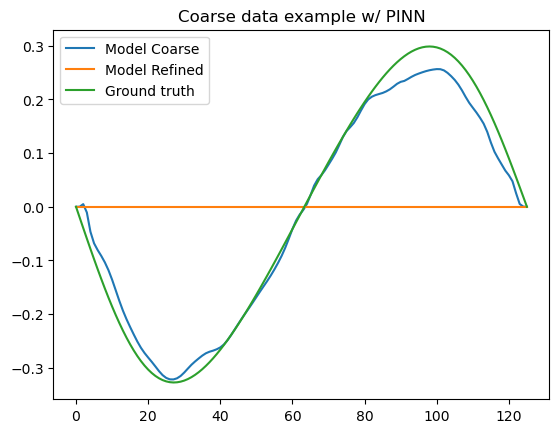

In [149]:
plt.plot(output_coarse_model_coarse_PINN.flatten(), label="Model Coarse")
plt.plot(output_refined_model_coarse_PINN.flatten(), label="Model Refined")
plt.plot(u_coarse[-1], label="Ground truth")
plt.title("Coarse data example w/ PINN")
plt.legend()

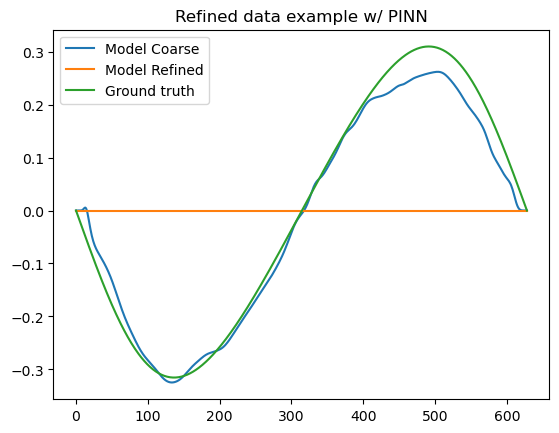

In [150]:
plt.plot(output_coarse_model_refined_PINN.flatten(), label="Model Coarse")
plt.plot(output_refined_model_refined_PINN.flatten(), label="Model Refined")
plt.plot(u_refined[-1], label="Ground truth")
plt.title("Refined data example w/ PINN")
plt.legend()

### <font size='3' color='blue'> Briefly comment on the results. Are your models more accurate? Less? Why do you think? How does the super-resolution result change? Any qualatative notes? </font>

1. The coarse-trained model becomes more accurate with PINN loss, achieving significantly lower test loss. However, 
the refined-trained model performs worse with PINN, showing degraded accuracy and even collapse.

2. I think for the coarse grid, the PINN loss acts as a helpful constraint and regularizer, improving stability. While for the refined grid, the PINN loss is too dominant; the model overfits the boundary and ignores the internal dynamics.

3. As for the super-resolution result change, the coarse model still generalizes well to refined data, showing strong super-resolution capability; The refined model fails on coarse data, showing almost constant output.

4. For qualatative notes, the coarse model gives reasonable predictions that closely match ground truth; The refined model outputs nearly all-zero results — boundary loss suppresses meaningful patterns.